In [2]:
import numpy as np
import pandas as pd
import os

### Download videos for training

Downloads videos as mp4 and saves the audio as mp3. mp4 may or may not contain audio due to the API being limited, though this should not matter (except for the small negative impact on file size). Currently videos are being downloaded in 720p since 1080p is inconsistent/bugged.

In [5]:
from pytube import YouTube 
  
urls = ["https://www.youtube.com/watch?v=Yt3-a9mExZg", "https://www.youtube.com/watch?v=cGt8bEcd9Ms", 'https://www.youtube.com/watch?v=w00ooES3D5Y']
urls = ['https://www.youtube.com/watch?v=w00ooES3D5Y']
pathVideo = 'Data/Video'
pathAudio = 'Data/Audio'

for i, url in enumerate(urls):
    print('yo')
    yt = YouTube(url)
    yt.streams.filter(abr="160kbps", progressive=False).first().download(filename="Audio"+str(i)+".mp3", output_path = pathAudio)
    yt.streams.filter(res="720p", progressive=False).first().download(filename="Video"+str(i)+".mp4", output_path= pathVideo)
##

yo


AttributeError: 'NoneType' object has no attribute 'span'

### Split video into frames

Goes through each downloaded video. Creates a directory per video inside 'tempFrames' and then saves the frames here. We can set the amount of frames we want per minute. Note that file sizes of these images can balloon quickly, exceeding the filesize of the video itself.

This code is mainly for early testing

In [10]:
import cv2
FRAMES_PER_MINUTE = 10
frame_counter = 60000 / FRAMES_PER_MINUTE
pathVideo = 'Data/Video/'
videoNames = []
for filename in os.listdir(pathVideo):
    f = os.path.join(pathVideo, filename)
    if os.path.isfile(f):
        if filename != '.gitignore':
            videoNames.append(filename)

for video in videoNames:
    path = pathVideo + video
    outputPath = 'Data/tempFrames/' + video[:-4] + '/' ## make directory per video
    if not os.path.exists(outputPath):
        os.mkdir(outputPath)
        print(f'Created new dir {outputPath}')
    vidcap = cv2.VideoCapture(pathVideo + video)
    success,image = vidcap.read()
    print(f'Succesful videocapture?: {success}')
    count = 0
    while success:
        cv2.imwrite(outputPath + "%d_seconds.jpg" % (count*(frame_counter/1000)), image)     # save frame as JPEG file   
        count += 1
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*frame_counter))   
        success,image = vidcap.read()
        

Succesful videocapture?: True
Succesful videocapture?: True


### Py-Feat

This library provides a pipeline containing multiple models related to facial detection. The most interesting aspect here is the output of AU's (action units), which will be a key part of predicting interest levels.

While the library works okay, it has difficulties with cuda and the documentation is lacking. The goal here is to use feat-py for prototyping and then later create a similar pipeline myself. This gives me more possibilities in for example fine-tuning, while also giving more control with regards to memory management and gpu usage. 

Action units cheat-sheet: https://py-feat.org/pages/au_reference.html

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import feat
from feat.facepose_detectors.img2pose.img2pose_test import Img2Pose
import torch
from torchvision import transforms
from PIL import Image
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Preprocessing.videoCropper import videoCropper
convert_tensor = transforms.ToTensor()

In [12]:
from feat.utils.io import get_test_data_path
from feat.plotting import imshow

# Helper to point to the test data folder
test_data_dir = get_test_data_path()

# Get the full path
single_face_img_path = os.path.join(test_data_dir, "single_face.jpg")

#single_face_prediction = detector.detect_image(single_face_img_path)
single_face_prediction = detector.detect_image('Data/testImages/ac3.jpg')

# Show results
single_face_prediction.plot_detections(au_barplot=False, emotion_barplot=False)
single_face_prediction

NameError: name 'detector' is not defined

In [1]:
from feat.utils.io import get_test_data_path
import os

test_data_dir = get_test_data_path()
test_video_path = os.path.join(test_data_dir, "WolfgangLanger_Pexels.mp4")
# test_video_path = "Data/Video/Video1.mp4"

# Show video
# from IPython.core.display import Video
# Video(test_video_path, embed=False)

##### Face detector and pose detector
The class `face_detector` contains a pretrained version of the `img2pose` model, which is finetuned to on frontal faces (like phone selfie cameras, webcams). It is imported through `py-feat`. It contains a `detection threshold` hyperparameter in the range of `[0,1]`. The model returns a dataframe where each row is a bounding box coordinates accompanied by 3 facial poses. We can also keep track of which frame the bounding box belongs in.

#### Video cropper
The video cropper checks the coordinates of each bounding box to determine the bounding box values closest to the top, bottom, left and right of the screen. It then crops crops the video to a lower resolution while maintaining all the neccessary information to extract features.

##### Face-tracker
The class `face_persistence_model` is based on the `face_recognition` library, using the `face_locations`, `face_encoding` and `face_landmarks `functions. `face_locations` searches a frame for faces and returns bounding box coordinates. `face_encoding` checks these faces to see if they can recognize the person. When it encounters a "new" face it saves some metadata. Then when detecting future faces it will check this new face against all the metadata files. `face_landmarks` returns 68 `x` and 68 `y` coordinates, representing the landmarks on a face. 

The inputs for the model are:
1. `TOLERANCE`: A number [0,1] that alters how the model recognizes faces. A too low tolerance leads to the same face getting detected as different unique faces, too high tolerance leads to multiple faces being detected as the same person 
2. `filename`: The name of the videofile being analyzed. Must contain extension such as ".mp4".
3. `frameSkips`: This integer value represents how often a frame is skipped, i.e. if `frameSkips=3` every 3rd frame is skipped.
4. `model`: Face location model choice of `['cnn', 'hog']`. While 'hog' is quicker (especially on CPU), 'cnn' is more accurate and utilizes GPU.
5. `modelSize`: Size of the face encoding model, choice of `['small', 'large']`.

#### AU and emotion detector
This class containg 2 models, namely a pretrained `XGB` model for detecting AU's and a `svm`/`resmasknet` model for emotion detection, which can be given as an input (`svm` is default).

The class uses facial landmarks and video footage as an input.




In [ ]:
import gc
import pandas as pd
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Models.eye_tracking.mediapipe_wrapper import mediaPipeModel
from Preprocessing.personLabeler import personPersistenceManual
from Preprocessing.videoCropper import videoCropper
from Preprocessing.kalman import filterKalman
import time

filename = 'meeting_3_trimmed.mp4'
mapName = 'meeting_3'
## TODO: batch size for models after facepredict and videocrop should correlate with number of people
##       example: with 3 people, batch_size=32 is perfect for aus+emo, but with 1 person batch_size=32 uses too little gpu memory and is slow.        

# facePredict = face_detector(filename=filename, detection_threshold=0.92, batch_size=8)
# output = facePredict.runModelBatch()
# output.to_csv(f'mapje/{mapName}/1_faceDetected.csv', index=False)
# del facePredict
# gc.collect()
# print('collected bounding_boxes')

# output = pd.read_csv(f'mapje/{mapName}/1_faceDetected.csv')
# output.fillna(method='ffill', inplace=True)
# output.to_csv('mapje/1.csv', index=False)

# videoCrop = videoCropper(output, filename, displayVideo=False, saveCSV=True)
# output = videoCrop.runModel(csvName='test')
filename = 'cropped_'+filename
# output.to_csv(f'mapje/{mapName}/2_cropped.csv', index=False)
# del videoCrop
# gc.collect()
# print('cropped video')


# p = personPersistenceManual(overlap_ratio=0.02)
# output = p.assign_person_id(output)
# output.to_csv(f'mapje/{mapName}/3_persistence.csv', index=False)
# del p
# gc.collect()
# print('did person tracking')


# face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large', landmark_cuda=True)
# output = face_tracker_model.runDetectionTrackOnlyBatch(output, False, batch_size=20)
# output.to_csv(f'mapje/{mapName}/4_landmarks.csv', index=False)
# del face_tracker_model
# gc.collect()
# print('completed landmarks')

output = pd.read_csv(f'mapje/{mapName}/4_landmarks.csv')


cols = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
kalmanFilter = filterKalman(output, cols)
output = kalmanFilter.runFilter()
output.to_csv(f'mapje/{mapName}/5_kalman.csv', index=False)
del kalmanFilter, cols
gc.collect()
print('completed kalman')

# output = pd.read_csv(f'mapje/{mapName}/5_kalman.csv')

au_emo_detector = AuEmoDetectors(filename=filename, df=output, emoModel='resmasknet', device='cuda')
output = au_emo_detector.runModel(batch_size=32)
output.to_csv(f'mapje/{mapName}/6_au_emo.csv', index=False)
del au_emo_detector
gc.collect()
print('completed au+emo')

start = time.time()
media = mediaPipeModel(filename=filename, df=output, display=False)
output = media.runModel()
output.to_csv(f'mapje/{mapName}/7_mediapipe.csv', index=False)
del media
gc.collect()
end = time.time()


30665    6
26092    6
26072    6
26073    6
26074    6
        ..
30404    3
30405    3
30406    3
30407    3
0        3
Name: Frame, Length: 30666, dtype: int64

In [1]:
import gc
import pandas as pd

import time
output = pd.read_csv(f'mapje/meeting_1/1_faceDetected.csv')

output[100:120]

c:\Users\Ramon\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\Ramon\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


,Frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,Pitch,Roll,Yaw
100,37,144.0,82.0,217.0,261.0,-12.826985,3.978004,-5.981948
101,37,244.0,455.0,164.0,194.0,-3.126256,-6.408949,-2.119776
102,38,849.0,100.0,249.0,287.0,-32.769034,-5.998078,9.703057
103,38,144.0,84.0,217.0,259.0,-12.830500,3.868735,-5.059678
104,38,244.0,453.0,162.0,195.0,-3.773196,-6.245763,-1.823594
105,38,939.0,469.0,94.0,107.0,23.154299,-0.369144,-2.774446
106,39,849.0,100.0,249.0,287.0,-32.813583,-5.949896,9.649875
107,39,145.0,82.0,216.0,260.0,-13.051646,3.726361,-4.347363
108,39,244.0,455.0,162.0,194.0,-3.743343,-6.247099,-1.824947
109,39,941.0,471.0,94.0,108.0,21.512102,-0.317309,-2.250685


In [ ]:
from feat import Detector
import cv2
det = Detector(face_model='retinaface', au_model='svm', emotion_model='svm', landmark_model='mobilenet', facepose_model='img2pose', device='cuda')
img = cv2.imread('mytestface.jpg')
det.detect_image('mytestface.jpg')

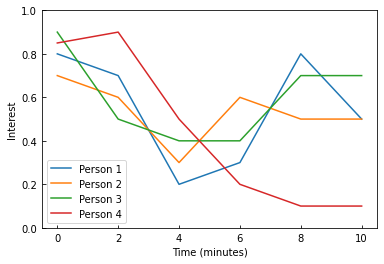

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time data (x-axis) from 0 to 10 in increments of 0.1 minutes
time = np.arange(0, 10.1, 2)

interestlist = []
interestlist.append([0.8, 0.7, 0.2, 0.3, 0.8, 0.5])
interestlist.append([0.7, 0.6, 0.3, 0.6, 0.5, 0.5])
interestlist.append([0.9, 0.5, 0.4, 0.4, 0.7, 0.7])
interestlist.append([0.85, 0.9, 0.5, 0.2, 0.1, 0.1])
interestlist.append([0.8, 0.8, 0.8, 0.8, 0.2, 0.2])
# Generate interest data (y-axis) between 0 and 1 for each person
interest_data = {}
for i, interest in zip(range(1, 5), interestlist):
    #np.random.seed(i)  # Set the seed for reproducibility
    #interest = np.random.uniform(0, 1, len(time))
    #interest=[0.8, 0.7, 0.2, 0.3, 0.8, 0.5]
    interest_data[f"Person {i}"] = interest

# Create the plot
fig, ax = plt.subplots()

# Plot the data for each person
for label, interest in interest_data.items():
    ax.plot(time, interest, label=label)

# Set the x-axis and y-axis labels
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Interest")

# Set the y-axis limits
ax.set_ylim(0, 1)

ax.tick_params(axis='both', direction='in', pad=5)

# Add a legend
ax.legend()


# Save the plot as a PNG file
plt.savefig("timeline_graph.png", dpi=300, bbox_inches="tight")

# Add a legend
ax.legend()

# Show the plot
plt.show()


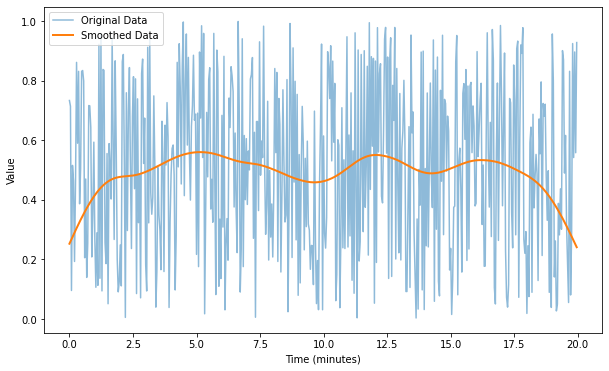

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
time = np.arange(0, 20, 1/25)
data = np.random.rand(len(time))

# Apply smoothing using a rolling window
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data

window_size = 25 * 5  # Experiment with different window sizes
smoothed_data = smooth_data(data, window_size, method='gaussian')  # or method='gaussian'

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, data, label='Original Data', alpha=0.5)
plt.plot(time, smoothed_data, label='Smoothed Data', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
import pandas as pd

df = pd.read_csv('mapje/1.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.to_csv('mapje/1.csv', index=False)



In [5]:
from Preprocessing.videoCropper import videoCropper
videoCrop = videoCropper(output, filename, displayVideo=False, saveCSV=True)
output = videoCrop.runModel(csvName='test')
filename = 'cropped_'+filename
del videoCrop
gc.collect()

right:1126 and left:248
3 619 616 878


495

In [ ]:
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Preprocessing.personLabeler import personPersistenceManual
import pandas as pd
import gc
output = pd.read_csv('updated_dataframe.csv')
filename = 'cropped_Video2_Trim_Trim.mp4'
lc=True
face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large', landmark_cuda=lc)
output2 = face_tracker_model.runDetectionTrackOnlyBatch(output, False, batch_size=32)
#output2 = face_tracker_model.runDetectionTrackOnly(output, False)

face_tracker_model.saveCSV(output2)
del face_tracker_model
gc.collect()

p = personPersistenceManual(overlap_ratio=0.2)
output3 = p.assign_person_id(output2)
output3.to_csv('beforeemo.csv', index=0)



In [ ]:
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
import pandas as pd
import numpy as np
filename = 'cropped_Video2_Trim_Trim.mp4'
output3 = pd.read_csv('beforeemo.csv')

det = AuEmoDetectors(filename, output3, emoModel='resmasknet')
output4 = det.runModel(separate=True)

In [ ]:
from feat import Detector
import cv2
img_data = cv2.imread('twofaces.jpg')
detector = Detector(emotion_model='resmasknet')
detected_faces = detector.detect_faces(img_data)
print(f'detected_faces: {detected_faces}')
detected_landmarks = detector.detect_landmarks(img_data, detected_faces)
print(f"detected_landmarks: {detected_landmarks}")

detected_emotions = detector.detect_emotions(img_data, detected_faces, detected_landmarks)
detected_aus = detector.detect_aus(img_data, detected_landmarks)
# print('yooo',detected_emotions)
# print('aaaaa', detected_aus)

### Video segmentation

To reduce memory usage it could be worthwile to only work with the video data inside of bounding boxes. I experimented with this in face_tracking_persistency.py

0    312
2    305
1    281
Name: Person, dtype: int64

In [ ]:
import numpy as np
import cv2
from feat import Detector
#emoModel = 'svm'
emoModel = 'resmasknet'
mydet = Detector(emotion_model=emoModel)

x_columns = [f'x{i}' for i in range(68)]
y_columns = [f'y{i}' for i in range(68)]
face_columns = ['FaceRectWidth', 'FaceRectHeight']
bbox_columns = ['FaceRectX', 'FaceRectWidth', 'FaceRectY', 'FaceRectHeight']
au_keys =      ["AU1","AU2","AU4","AU5","AU6","AU7","AU9","AU10","AU11","AU12","AU14",
                "AU15","AU17","AU20","AU23","AU24","AU25","AU26","AU28","AU43"]
emotion_keys = ['anger', 'disgust', 'fear',	'happiness', 'sadness',	'surprise',	'neutral']
auDF = pd.DataFrame(index=range(len(output)), columns=au_keys)
emoDF = pd.DataFrame(index=range(len(output)), columns=emotion_keys)
video = cv2.VideoCapture('./Data/Video/'+filename)
frame_i = 0
total_iterator = 0

output = pd.read_csv('facial_persistence_test_cropped_Video2_Trim_Trim.mp4_cropped.csv')

while True:
    ret, image = video.read()
    if ret == False:
        break
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    grouped = output.groupby('Frame')
    for frame, group in grouped:
        if frame == frame_i:
            frame_group = group
            break
    tempRowList = []
    for _, row in frame_group.iterrows():
        x_array = row[x_columns].tolist()
        y_array = row[y_columns].tolist()
        coordinates = list(zip(x_array, y_array))
        coordinates = np.array(coordinates, dtype=np.float32)
        nested_coordinates = [[coordinates]]
        aus = mydet.detect_aus(image, nested_coordinates)
        for (x,y) in coordinates:
            print(x,y)
        if emoModel == 'svm':
            emotions = mydet.detect_emotions(frame=image, facebox=['a','b'], landmarks=nested_coordinates)
        else:
            faceInfo = row[bbox_columns].tolist()
            faceInfo.append(1)
            faceInfo = [int(x) for x in faceInfo]
            faceInfo = [[faceInfo]]
            emotions = mydet.detect_emotions(frame=image, facebox=faceInfo, landmarks=nested_coordinates)
        for name, key in zip(au_keys,aus[0][0]):
            auDF.loc[total_iterator, name] = key
        for name, key in zip(emotion_keys, emotions[0][0]):
            emoDF.loc[total_iterator, name] = key
        total_iterator += 1
    
output2 = output.copy(deep=True)
output2 = pd.concat([output2, auDF, emoDF], axis=1)
output2.to_csv('final.csv', index=False)

In [2]:
import numpy as np
import pandas as pd
import gc
from Preprocessing.videoCropper import videoCropper
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
filename = 'Video2_Trim_Trim.mp4'
face_detector_model = face_detector(filename=filename, detection_threshold=0.5)
output = face_detector_model.runModel()
del face_detector_model
gc.collect()
videoCrop = videoCropper(output, filename, displayVideo=False, saveCSV=True)
output = videoCrop.runModel(csvName='test')
filename = 'cropped_'+filename
del videoCrop
gc.collect()

#output = pd.read_csv('facial_persistence_test_cropped_Video2_Trim_Trim.mp4_cropped.csv')
face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large')
output = face_tracker_model.runDetectionTrackOnly(output, False)
face_tracker_model.saveCSV(output)
del face_tracker_model
gc.collect()
au_emo_detector = AuEmoDetectors(filename=filename, df=output, emoModel='svm')
output2 = au_emo_detector.runModel()

Video loaded? :  True
Video loaded? :  True


In [ ]:
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
import numpy as np
import pandas as pd
faceData = pd.DataFrame(columns=['Frame', 'FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight'])

filename = 'recording_p0_trimmed.mp4'
filename = 'cropped_'+filename
output = pd.read_csv('updated_dataframe_p0_trimmed.csv')

face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large')
output = face_tracker_model.runModel_single_person(output, False)
face_tracker_model.saveCSV(output)

In [3]:
from Preprocessing.kalman import filterKalman

cols = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
filterr = filterKalman(output, cols)
output2 = filterr.runFilter()

person:  1


In [4]:
import gc
del filterr
del face_tracker_model
gc.collect()

0

In [ ]:
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
filename = 'recording_p0_trimmed.mp4'
filename = 'cropped_'+filename
emoDet = AuEmoDetectors(filename, output2, emoModel='resmasknet', device='cuda')
output3 = emoDet.runModel()

In [24]:
output3[:3]
columns = ['FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
otherColumns = [f'x{i}' for i in range(68)] + [f'y{i}' for i in range(68)]
float_columns = ['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU11','AU12','AU14','AU15'
                 ,'AU17','AU23','AU24','AU25','AU26','AU28','AU43'
                 ,'anger','disgust','fear','happiness','sadness','surprise','neutral']


df = output3.copy()

# Column names to cast to int

# Column names to round to 3 decimal places

# Cast columns to int
for column in columns:
    df[column] = df[column].apply(lambda x: int(x))
    
for column in otherColumns:
    df[column] = df[column].apply(lambda x: int(x))

# Round float columns to the 3rd decimal
for column in float_columns:
    df[column] = df[column].apply(lambda x: round(x, 3))
    
df.to_csv('echtDeLaatste.csv', sep=';', index=False)




,Frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,Pitch,Roll,Yaw,Person,x0,...,AU26,AU28,AU43,anger,disgust,fear,happiness,sadness,surprise,neutral
0,0,72,12,197,249,2.470358,0.581049,-0.440886,1,75,...,0.251,0.078,0.111,0.048,0.000,0.0,0.0,0.006,0.000,0.945
1,1,66,9,199,254,2.529597,-0.112156,-3.731396,1,77,...,0.284,0.337,0.270,0.095,0.001,0.0,0.0,0.006,0.004,0.893


In [ ]:
import face_alignment
import cv2
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch


filename = 'recording_p0_trimmed.mp4'
filename = 'cropped_'+filename
video = cv2.VideoCapture('./Data/Video/'+filename)
print('Video loaded? : ', video.isOpened())

faceData = pd.DataFrame(columns=['Frame', 'FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight'])
model = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda', flip_input=False)

output = pd.read_csv('updated_dataframe_p0_trimmed.csv')
df = output.copy()
batch_size = 200
current_batch = 0
columns = ['Frame', 'FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']
for i in range(68):
    columns.extend([f'x{i}', f'y{i}'])
result_df = pd.DataFrame(columns=columns)

stop = False
while True:
    frame_range = range(current_batch, current_batch + batch_size)
    filtered_df = df[df['Frame'].isin(range(current_batch, current_batch+batch_size))]
    image_batch = []
    bounding_boxes_batch = []

    xyz = 0
    for frame_number in range(current_batch, current_batch+batch_size):
        ret, img = video.read()
        if ret == False:
            stop = True
            batch_size = xyz
            break
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).to('cuda')
        img = img.unsqueeze(0)  # Add batch dimension
        image_batch.append(img)

        frame_bboxes = filtered_df[filtered_df['Frame'] == frame_number]
        frame_bboxes = [(row['FaceRectX'], row['FaceRectY'], row['FaceRectX'] + row['FaceRectWidth'], row['FaceRectY'] + row['FaceRectHeight']) for _, row in frame_bboxes.iterrows()]
        bounding_boxes_batch.append(frame_bboxes)
        xyz += 1

    image_batch = torch.cat(image_batch, axis=0).to('cuda')
    landmarks = model.get_landmarks_from_batch(image_batch, detected_faces=bounding_boxes_batch)
    
    frame_range = range(current_batch, current_batch + batch_size)
    # Process the results
    for frame, landmarks_list in zip(frame_range, landmarks):
        if landmarks_list is not None:
            if landmarks_list.shape[0] == 68:
                for i, single_landmark in enumerate(landmarks_list):  # Moved the enumerator up one level
                    x, y = single_landmark
                    landmark_data = {f'x{i}': x, f'y{i}': y}

                    # Update the DataFrame with the landmark data
                    mask = df['Frame'] == frame
                    row = df.loc[mask].iloc[0].to_dict()
                    row.update(landmark_data)
                    result_df = result_df.append(row, ignore_index=True)
            else:
                for j, single_person in enumerate(landmarks_list):
                    for i, single_landmark in enumerate(single_person):
                        x, y = single_landmark
                        landmark_data = {f'x{i}': x, f'y{i}': y}

                        # Update the DataFrame with the landmark data
                        mask = df['Frame'] == frame
                        row = df.loc[mask].iloc[j].to_dict()
                        row.update(landmark_data)
                        result_df = result_df.append(row, ignore_index=True)

    current_batch += batch_size
    print('batch finished')
    torch.cuda.empty_cache()
    if stop:
        break
print(result_df)


In [10]:
import face_alignment
import cv2
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch

img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')
img1 = torch.from_numpy(img1).permute(2, 0, 1).float() / 255.0
img2 = torch.from_numpy(img2).permute(2, 0, 1).float() / 255.0
image_batch = [img1, img2]
image_batch2 = [img2]
model = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cuda', flip_input=False)

image_batch2 = [torch.stack(image_batch2).to('cuda')]
image_batch = torch.stack(image_batch).to('cuda')



[[], []]


In [ ]:
import numpy as np
import pandas as pd
import gc
from Preprocessing.videoCropper import videoCropper
from Models.face_detection.face_detection import face_detector
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from feat.landmark_detectors.mobilefacenet_test import MobileFaceNet

filename = 'recording_p0_trimmed.mp4'

# face_detector_model = face_detector(filename=filename, detection_threshold=0.5, batch_size=512)
# output = face_detector_model.runModelBatchSingleFace()
# output.to_csv('p0_trimmed_initial.csv')
# del face_detector_model
# gc.collect()

# output = pd.read_csv('p0_initial.csv')
# print(output.Frame.duplicated().sum())
# aa = output.loc[output.Frame.duplicated(), :]
# aa[:10]
# videoCrop = videoCropper(output, filename, displayVideo=True, saveCSV=True)
# output = videoCrop.runModel(csvName='test')
# filename = 'cropped_'+filename
# del videoCrop
# gc.collect()


filename = 'cropped_'+filename
output = pd.read_csv('updated_dataframe_p0_trimmed.csv')

FacePersistenceModel = face_persistence_model(TOLERANCE=0.6,filename=filename)
output2 = FacePersistenceModel.runModel_single_person(output)
output2.to_csv('landmarks_detected_p0.csv')

In [2]:
import pandas as pd
import cv2
import numpy as np
myvideo = cv2.VideoCapture('Data/pafe/data/p0/recording.mp4')
total_frames = int(myvideo.get(cv2.CAP_PROP_FRAME_COUNT))
df2 = pd.DataFrame({'Frame': range(total_frames)})
df2.to_csv('test2.csv')
# Read the file into a DataFrame
# Print the total number of frames
print('Total frames:', total_frames)

# Release the video object
myvideo.release()


# Read the timestamps from the first file
with open("Data/pafe/data/p0/video_timeline_without_end.txt", "r") as f:
    frame_timestamps = [float(line.strip()) for line in f if line.strip() != '']

# Read the probe data from the second file
with open("Data/pafe/data/p0/probe_main_video.txt", "r") as f:
    probes = [line.strip().split(',') for line in f]

# Function to find the index of the nearest timestamp
def find_nearest_index(array, value):
    idx = (np.abs(np.array(array) - value)).argmin()
    return idx

# Initialize the labeled_frames list with default labels "n"
labeled_frames = ["n"] * len(frame_timestamps)

frameNumber = []
# Iterate through the probe data and label the frames
for probe in probes:
    if probe[2] == "probe":
        nearest_idx = find_nearest_index(frame_timestamps, float(probe[1]))
        start_idx = max(0, nearest_idx - 600)
        for i in range(start_idx, nearest_idx):
            labeled_frames[i] = probe[3]

# Create a DataFrame with the labeled frames
df = pd.DataFrame({"Frame_time": frame_timestamps, "label": labeled_frames})
df['Frame'] = range(len(df))
# Print the DataFrame
print(len(frame_timestamps))
print(frame_timestamps[0])
print(frame_timestamps[-1])

print(df)
print(df2)

if len(frame_timestamps) != len(set(frame_timestamps)):
    print("There are duplicates in the list.")
else:
    print("There are no duplicates in the list.")


df.to_csv('test.csv')
df2.to_csv('test2.csv')
print(df.label.value_counts())

Total frames: 124005
124005
1622963840.502918
1622967974.098509
          Frame_time label   Frame
0       1.622964e+09     n       0
1       1.622964e+09     n       1
2       1.622964e+09     n       2
3       1.622964e+09     n       3
4       1.622964e+09     n       4
...              ...   ...     ...
124000  1.622968e+09     n  124000
124001  1.622968e+09     n  124001
124002  1.622968e+09     n  124002
124003  1.622968e+09     n  124003
124004  1.622968e+09     n  124004

[124005 rows x 3 columns]
         Frame
0            0
1            1
2            2
3            3
4            4
...        ...
124000  124000
124001  124001
124002  124002
124003  124003
124004  124004

[124005 rows x 1 columns]
There are no duplicates in the list.
n    86205
y    37800
Name: label, dtype: int64


In [ ]:
final_df = pd.read_csv('finalfinalfinal.csv')
labels_df = pd.read_csv('test.csv')

final_df_length = len(final_df)
labels_slice = labels_df['label'][:final_df_length]

final_df['label'] = labels_slice

final_df.to_csv('final_met_labels.csv')

## FOR USAGE WITH VIDEO

In [ ]:
import gc
import pandas as pd
import cv2
import numpy as np
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Preprocessing.videoCropper import videoCropper
import mediapipe as mp
import math


mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh()
LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
RIGHT_EYE= [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246] 

def gaze_direction(eye_subframe, pupil_coords):
    x, y, _ = pupil_coords
    width, height = eye_subframe.shape[1], eye_subframe.shape[0]
    gaze_threshold = width // 4
    if x < gaze_threshold:
        return "left"
    elif x > width - gaze_threshold:
        return "right"
    else:
        return "center"
    
def detect_pupil(eye_subframe):
    gray = cv2.cvtColor(eye_subframe, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Filter contours based on size and aspect ratio
    filtered_contours = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if 0.2 < aspect_ratio < 5 and cv2.contourArea(contour) > 10:
            filtered_contours.append(contour)

    if not filtered_contours:
        return None

    max_contour = max(filtered_contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(max_contour)
    return int(x), int(y), int(radius)   

filename = 'Video2_Trim_Trim.mp4'

filename = 'cropped_'+filename
output = pd.read_csv('facial_persistence_test_cropped_Video2_Trim_Trim.mp4_cropped.csv')

output[:20]

x_columns = [f'x{i}' for i in range(68)]
y_columns = [f'y{i}' for i in range(68)]
bbox_columns = ['FaceRectX', 'FaceRectWidth', 'FaceRectY', 'FaceRectHeight']

video = cv2.VideoCapture('./Data/Video/'+filename)
print('Video loaded? : ', video.isOpened())

blue = [255, 255, 0]
cyan =  [255, 0, 0]
red = [0,0,255]

frame_i = 0
total_iterator = 0

RIGHT_IRIS = [474, 475, 476, 477]
LEFT_IRIS = [469, 470, 471, 472]
L_H_LEFT = [33]  # right eye right most landmark
L_H_RIGHT = [133]  # right eye left most landmark
R_H_LEFT = [362]  # left eye right most landmark
R_H_RIGHT = [263]  # left eye left most landmark

def euclidian_distance(p1, p2):
    x1, y1 = p1.ravel()
    x2, y2 = p2.ravel()
    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

def irisPosition(iris_center, right_point, left_point):
    center_to_right_distance = euclidian_distance(iris_center, right_point)
    #center_to_left_distance = euclidian_distance(iris_center, left_point)
    total_distance = euclidian_distance(right_point, left_point)
    ratio = center_to_right_distance/total_distance
    iris_position = ''
    if ratio <= 0.42:
        iris_position = 'right'
    elif ratio >= 0.42 and ratio <= 0.57:
        iris_position = 'center'
    else:
        iris_position = 'left'
    return iris_position, ratio
        
display = True
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:
    while True:
        ret, image = video.read()
        if ret == False:
            break
        
        grouped = output.groupby('Frame')
        for frame, group in grouped:
            if frame == frame_i:
                frame_group = group
                break        
        
        frame_rows = output[output['Frame'] == frame_i]
        for _, row in frame_group.iterrows():  
            left, width, top, height = row[bbox_columns]  
            left = int(left)
            right = int(left + width)
            top = int(top)
            bottom = int(top + height)
           
            face_frame = image[top:bottom, left:right] ## this is the bounding box of a face
            img_h, img_w = face_frame.shape[:2]
            
            results = face_mesh.process(face_frame)
            
            if results.multi_face_landmarks:
                mesh_points=np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in results.multi_face_landmarks[0].landmark])

                (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(mesh_points[LEFT_IRIS])
                (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(mesh_points[RIGHT_IRIS])
                center_left = np.array([l_cx, l_cy], dtype=np.int32)
                center_right = np.array([r_cx, r_cy], dtype=np.int32)
                top_left = (top, left)
                bottom_right = (bottom, right)
                center_left_full = tuple(a + b for a, b in zip(center_left, top_left))
                center_right_full = tuple(a + b for a, b in zip(center_right, top_left))

                if display:
                    cv2.circle(face_frame, center_left, int(l_radius), (255,0,255), 1, cv2.LINE_AA)
                    cv2.circle(face_frame, center_right, int(r_radius), (255,0,255), 1, cv2.LINE_AA)
                    cv2.circle(face_frame, mesh_points[R_H_RIGHT][0], 2, (255,255,255), 2, cv2.LINE_AA)
                    cv2.circle(face_frame, mesh_points[R_H_LEFT][0], 2, (0,255,255), 2, cv2.LINE_AA)
                iris_pos, ratio = irisPosition(center_right, mesh_points[R_H_RIGHT][0], mesh_points[R_H_LEFT][0])
                print(f'right eye left side = {left + mesh_points[R_H_LEFT][0][0]}, right eye right side = {left + mesh_points[R_H_RIGHT][0][0]}\n' +
                      f'left eye left side = {left + mesh_points[L_H_LEFT][0][0]}, left eye right side = {left + mesh_points[L_H_RIGHT][0][0]}\n', 
                      f'iris and ratio = {iris_pos, ratio}')
            else:
                print('nothing')
                
            if display:
                cv2.circle(face_frame, center_left + (left, top), int(l_radius), (255,0,255), 1, cv2.LINE_AA)
                cv2.imshow('img', image)
                if cv2.waitKey(int(1000/30)) & 0xFF == ord('q'):
                    video.release()
                    cv2.destroyAllWindows()
                    break
            # Wait for 1/fps seconds before displaying the next frame

            
            frame_i += 1


    if display:
        video.release()
        cv2.destroyAllWindows()



## FOR WEBCAM USAGE

In [1]:
import gc
import pandas as pd
import cv2
import numpy as np
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Preprocessing.videoCropper import videoCropper
import mediapipe as mp
import math


mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh()
LEFT_EYE = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]
RIGHT_EYE= [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246] 

blue = [255, 255, 0]
cyan =  [255, 0, 0]
red = [0,0,255]

RIGHT_IRIS = [474, 475, 476, 477]
LEFT_IRIS = [469, 470, 471, 472]
L_H_LEFT = [33]  # right eye right most landmark
L_H_RIGHT = [133]  # right eye left most landmark
R_H_LEFT = [362]  # left eye right most landmark
R_H_RIGHT = [263]  # left eye left most landmark

def euclidian_distance(p1, p2):
    x1, y1 = p1.ravel()
    x2, y2 = p2.ravel()
    distance = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

def irisPosition(iris_center, right_point, left_point):
    center_to_right_distance = euclidian_distance(iris_center, right_point)
    #center_to_left_distance = euclidian_distance(iris_center, left_point)
    total_distance = euclidian_distance(right_point, left_point)
    ratio = center_to_right_distance/total_distance
    iris_position = ''
    if ratio <= 0.45:
        iris_position = 'right'
    elif ratio >= 0.45 and ratio <= 0.54:
        iris_position = 'center'
    else:
        iris_position = 'left'
    return iris_position, ratio
      
      
video = cv2.VideoCapture(0)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as face_mesh:
    while True:
        ret, image = video.read()
        if ret == False:
            break
           
        img_h, img_w = image.shape[:2]
        results = face_mesh.process(image)
        
        if results.multi_face_landmarks:
            mesh_points=np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in results.multi_face_landmarks[0].landmark])

            (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(mesh_points[LEFT_IRIS])
            (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(mesh_points[RIGHT_IRIS])
            center_left = np.array([l_cx, l_cy], dtype=np.int32)
            center_right = np.array([r_cx, r_cy], dtype=np.int32)
            cv2.circle(image, center_left, int(l_radius), (255,0,255), 1, cv2.LINE_AA)
            cv2.circle(image, center_right, int(r_radius), (255,0,255), 1, cv2.LINE_AA)
            cv2.circle(image, mesh_points[R_H_RIGHT][0], 2, (255,255,255), 1, cv2.LINE_AA)
            cv2.circle(image, mesh_points[R_H_LEFT][0], 2, (0,255,255), 1, cv2.LINE_AA)
            iris_pos, ratio = irisPosition(center_right, mesh_points[R_H_RIGHT][0], mesh_points[R_H_LEFT][0])
            print(ratio)
        cv2.imshow('img', image)



        # Wait for 1/fps seconds before displaying the next frame

        
        #frame_i += 1
        if cv2.waitKey(int(1000/3)) & 0xFF == ord('q'):
            video.release()
            cv2.destroyAllWindows()
            break

    video.release()
    cv2.destroyAllWindows()



c:\Users\Ramon\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\Ramon\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


0.26559258100921596
0.501866839101296
0.45675013919556984
0.48623217215607667
0.4369511139617778
0.43866732506766326
0.46022337571613586
0.38391703563326424
0.31862649393858306
0.47398052095690113
0.5153882032022076
0.4883769394749725
0.6008783293931309
0.4836378597661081
0.488558642930307
0.5029825573431478
0.41522739926869984
0.44172610429938614
0.4429745084023906
0.44172610429938614
0.45868948059003967
0.417612260356422
0.39801487608399566
0.38208035995043504
0.5359213935288726
0.4386146514880687
0.43514263457633695
0.45146611838648026
0.47527710324935335
0.43843154793219685
0.4694487891187872
0.46974808707021093
0.4456794105478751
0.46974808707021093
0.4694487891187872
0.5298766184398316
0.4472135954999579
0.40880715217720065
0.3091734712004211
0.3684871064282085
0.4235702594681104
0.438598722555895
0.7371298621032363
0.44476644391371384
0.4235702594681104
0.47823281422930214
0.7983002173331908
0.4235702594681104
0.46584749531245623
0.4757429568020377
0.4406386689207194
0.526067964

In [4]:
import gc
import pandas as pd
import cv2
import numpy as np
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Preprocessing.videoCropper import videoCropper
import mediapipe as mp
import math
from Models.eye_tracking.mediapipe_wrapper import mediaPipeModel

filename = 'Video2_Trim_Trim.mp4'
filename = 'cropped_'+filename
output = pd.read_csv('facial_persistence_test_cropped_Video2_Trim_Trim.mp4_cropped.csv')
media = mediaPipeModel(filename, output, True)
media.runModel()


FileNotFoundError: [Errno 2] No such file or directory: 'facial_persistence_test_cropped_Video2_Trim_Trim.mp4_cropped.csv'